# GRP → wavelet CWT → AE

In [9]:
import numpy as np
import pywt
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Model
import tensorflow as tf

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel, RBF


# ============================================================
# 0) 設定（ここだけ調整）
# ============================================================
NPZ_PATH = "dataset_irregular.npz"

L_GRID   = 256                  # 等間隔グリッド（CWT横幅）
N_SCALES = 64                   # CWT縦幅（MaxPool2回なので4の倍数推奨）
# 位相情報（横ずれ）を残すため複素ウェーブレットを使う
WAVELET  = "cmor1.5-1.0"        # 複素Morlet（PyWavelets表記）

TRAIN_RATIO = 0.70              # 正常のうちAE学習用
VAL_RATIO   = 0.10              # 正常のうち学習の監視用（任意）
CAL_RATIO   = 0.20              # 正常のうち閾値決定用（AE学習に使わない）
THR_Q       = 0.995             # calib正常スコアの分位点で閾値

EPOCHS = 50
BATCH  = 64
LR     = 1e-3
SEED   = 0

np.random.seed(SEED)
tf.random.set_seed(SEED)

assert (L_GRID % 4 == 0) and (N_SCALES % 4 == 0), "L_GRID と N_SCALES は 4 の倍数推奨（MaxPool2回のため）"
assert abs((TRAIN_RATIO + VAL_RATIO + CAL_RATIO) - 1.0) < 1e-9, "TRAIN/VAL/CAL の比率の合計を 1.0 にしてください"

# ============================================================
# 1) 読み込み（1サンプル=[cycle_id, deg, s1, label]）
# ============================================================
d = np.load(NPZ_PATH, allow_pickle=True)
train_list = d["train_list"].tolist()
test_list  = d["test_list"].tolist()

def group_by_cycle(sample_list):
    arr = np.asarray(sample_list, dtype=object)
    cid = arr[:,0].astype(int)
    deg = arr[:,1].astype(float)
    y   = arr[:,2].astype(float)
    lab = arr[:,3].astype(int)

    order = np.lexsort((deg, cid))   # cycle→deg
    cid, deg, y, lab = cid[order], deg[order], y[order], lab[order]

    cycles = {}
    start = 0
    while start < len(cid):
        c = int(cid[start])
        end = start
        while end < len(cid) and int(cid[end]) == c:
            end += 1
        cycles[c] = (deg[start:end], y[start:end], int(lab[start]))
        start = end
    return cycles

train_cycles = group_by_cycle(train_list)
test_cycles  = group_by_cycle(test_list)

def count_labels_from_cycles(cycles_dict):
    labs = np.array([lab for (_,_,lab) in cycles_dict.values()], dtype=int)
    u, c = np.unique(labs, return_counts=True)
    return {int(k): int(v) for k, v in zip(u, c)}

print("\n[cycle counts]")
print("train cycles total:", len(train_cycles))
print("test  cycles total:", len(test_cycles))
print("train label counts:", count_labels_from_cycles(train_cycles))
print("test  label counts:", count_labels_from_cycles(test_cycles))



[cycle counts]
train cycles total: 700
test  cycles total: 1020
train label counts: {0: 700}
test  label counts: {0: 720, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


In [10]:

# ============================================================
# 2) グリッドとCWTスケール
# ============================================================

deg_grid = np.linspace(0, 360, L_GRID, endpoint=False).astype(float)
deg_step = float(deg_grid[1] - deg_grid[0])

# ---- CWTスケールを「見たい高調波次数 k（1周期=360度あたり何回振動するか）」から決める ----
# ナイキスト上限（これを超えるkは表現できず不安定になりやすい）
k_nyq = int(np.floor(360.0 / (2.0 * deg_step)))  # = L_GRID//2 と同じ

K_MIN = 2                       # 低周波側（例: 2次以上を見る。1次も見たいなら 1）
K_MAX = min(k_nyq, 128)         # 高周波側（k_nyq を超えないように）

# kを対数間隔で並べる（低周波も高周波もバランス良く拾える）
k = np.geomspace(K_MIN, K_MAX, N_SCALES).astype(float)

# scale2frequency の中心周波数（scale=1のとき）を使って scale を逆算
# f(cycles/deg) = k/360,  f = scale2frequency(wavelet, scale) / sampling_period
cf = float(pywt.scale2frequency(WAVELET, 1.0))
scales = cf / ((k / 360.0) * deg_step)
scales = np.clip(scales, 1e-6, None)  # scaleは正

# 確認（実際にそのscaleがどのk相当かを逆算して表示）
scale2freq_vec = np.vectorize(lambda s: pywt.scale2frequency(WAVELET, float(s)))
k_check = 360.0 * (scale2freq_vec(scales) / deg_step)

print(f"deg_step={deg_step:.6f} [deg], Nyquist k <= {k_nyq}")
print(f"k target   : {K_MIN:.2f} .. {K_MAX:.2f}")
print(f"k realized : {k_check.min():.2f} .. {k_check.max():.2f}")
print(f"scales     : {float(scales.min()):.3f} .. {float(scales.max()):.3f} (N={len(scales)})")
k_check


deg_step=1.406250 [deg], Nyquist k <= 128
k target   : 2.00 .. 128.00
k realized : 2.00 .. 128.00
scales     : 2.000 .. 128.000 (N=64)


array([  2.        ,   2.13648338,   2.28228062,   2.43802731,
         2.60440241,   2.78213124,   2.97198858,   3.1748021 ,
         3.39145597,   3.62289466,   3.87012711,   4.13423113,
         4.41635805,   4.7177378 ,   5.0396842 ,   5.38360077,
         5.75098679,   6.14344385,   6.56268285,   7.01053142,
         7.48894194,   8.        ,   8.54593353,   9.12912248,
         9.75210923,  10.41760966,  11.12852495,  11.88795431,
        12.69920842,  13.56582387,  14.49157863,  15.48050846,
        16.53692453,  17.66543222,  18.87095118,  20.1587368 ,
        21.53440308,  23.00394716,  24.57377541,  26.25073139,
        28.04212569,  29.95576776,  32.        ,  34.18373411,
        36.51648992,  39.00843693,  41.67043863,  44.51409982,
        47.55181725,  50.79683366,  54.26329548,  57.96631451,
        61.92203383,  66.14769811,  70.66172888,  75.48380473,
        80.63494719,  86.13761233,  92.01578864,  98.29510163,
       105.00292557, 112.16850275, 119.82307103, 128.  

# このスケール設計セルがやっていること（要点）

目的は「CWTのスケール `scales` を、直感的な指標である高調波次数 `k`（1サイクル=360度で何回振動するか）から設計する」ことです。

---

# 1) グリッドと刻み幅

`deg_grid` は 0〜360度を `L_GRID` 点で等間隔に並べた角度グリッド。  
`deg_step` はその刻み幅で、

$deg\_step=\dfrac{360}{L\_GRID}$

これは「1サンプルが何度に相当するか」を表します。

---

# 2) ナイキスト上限 $k\_{nyq}$ の意味

等間隔サンプリングでは、折り返しが起きない最大周波数がナイキストです。  
角度軸で見ると「1サイクル（360度）あたりの最大振動回数（高調波次数）」は

$k\_{nyq}=\dfrac{360}{2\,deg\_step}=\dfrac{L\_GRID}{2}$

これより大きい `k` を含めると、高周波成分が低周波に化けて見える（折り返し）ため、CWTが不安定になりやすいです。  
このため `K_MAX <= k_nyq` の制約を入れています。

---

# 3) `K_MIN` と `K_MAX` は「見たい周波数帯」を決めるつまみ

- `K_MIN`: 低周波側の下限（小さいほどゆっくり変化を見る）
- `K_MAX`: 高周波側の上限（大きいほど細かい変化を見る）

例：
- `K_MIN` を上げる → DCやゆっくり変化（上下シフト・基線ゆらぎ）に鈍くなる
- `K_MAX` を下げる → 高周波（スパイク・高周波異常）に鈍くなる

---

# 4) `k` を対数間隔 `geomspace` にする理由

$k=\mathrm{geomspace}(K\_{MIN},K\_{MAX},N\_{SCALES})$

低周波も高周波も「相対的にバランス良く」刻めます。線形刻みだと高周波に点が偏り、低周波が粗くなりがちです。

---

# 5) スケール `scales` の計算原理

PyWavelets の擬似周波数の定義は

$f\;(\mathrm{cycles/deg})=\dfrac{\mathrm{scale2frequency}(\mathrm{wavelet},\,s)}{\mathrm{sampling\_period}}$

ここで `sampling_period = deg_step` なので

$f=\dfrac{\mathrm{scale2frequency}(\mathrm{wavelet},\,s)}{deg\_step}$

高調波次数 `k`（360度で何回振動）との関係は

$k=360\,f$

よって

$k = 360\cdot\dfrac{\mathrm{scale2frequency}(\mathrm{wavelet},\,s)}{deg\_step}$

多くのウェーブレットでは

$\mathrm{scale2frequency}(\mathrm{wavelet},\,s)\approx\dfrac{cf}{s}$

（$cf$ は scale=1 の中心周波数）なので

$k \approx 360\cdot\dfrac{cf/s}{deg\_step}$

これを $s$ について解くと

$s \approx \dfrac{360\,cf}{k\,deg\_step}$

これがコードの

`cf = scale2frequency(WAVELET, 1.0)`  
`scales = cf / ((k/360)*deg_step)`

に対応します（同じ式を形を変えて書いただけです）。

---

# 6) `k_check` でやっている「逆算チェック」

設計した `scales` が狙った `k` に対応しているかを確認するために

$k\_{check}=360\cdot\dfrac{\mathrm{scale2frequency}(\mathrm{wavelet},\,s)}{deg\_step}$

を各スケールで計算し、

- `k target`（設計上の範囲）
- `k realized`（実際に対応している範囲）

がだいたい一致していることを確かめています。

---

# 7) この設計の直感

- `scales` が小さい → 高周波（大きい `k`）を見る
- `scales` が大きい → 低周波（小さい `k`）を見る

つまり「CWTの縦軸（スケール）を、見たい高調波次数の範囲に合うように並べ替えた」ことになります。

---

# 8) 何を調整すれば何が変わるか

- `L_GRID` を増やす：$k\_{nyq}=L\_{GRID}/2$ が上がり、より高周波まで見られる
- `K_MIN` を下げる：より低周波（ゆっくり変化）を含める
- `K_MAX` を上げる：より高周波を含める（ただし $k\_{nyq}$ 以下）
- `N_SCALES` を増やす：縦方向の分解能（帯域の刻み）を上げる
- `geomspace` → `linspace`：帯域の刻みの偏り方が変わる（低周波の表現が粗くなりやすい）

In [11]:

# ============================================================
# 3) GPR（重要: normalize_y=False で上下シフトを消さない）
#    まず正常1サイクルでカーネルのパラメータを自動推定 → 固定
# ============================================================
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel

def fit_kernel_on_one_cycle(deg, y):
    X = deg.reshape(-1, 1).astype(float)
    y = y.astype(float)

    # 周期=360°を固定（既知なら固定が安定）
    kernel0 = ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(
        length_scale=10.0,                 # 初期値は適当でOK（fitで動く）
        periodicity=360.0,
        length_scale_bounds=(0.2, 200.0),  # 小さめを許すほど高周波まで追える
        periodicity_bounds="fixed"
    ) + WhiteKernel(
        noise_level=0.05,
        noise_level_bounds=(1e-6, 1.0)
    )

    gpr = GaussianProcessRegressor(
        kernel=kernel0,
        normalize_y=False,
        n_restarts_optimizer=5,
        random_state=SEED
    )
    gpr.fit(X, y)
    return gpr.kernel_



normal_ids = [cid for cid, (_, _, lab) in train_cycles.items() if lab == 0]
if len(normal_ids) == 0:
    raise ValueError("trainに label==0（正常）がありません。")

deg0, y0, _ = train_cycles[normal_ids[0]]
kernel_frozen = fit_kernel_on_one_cycle(deg0, y0)
print("\nlearned kernel:", kernel_frozen)



learned kernel: 0.705**2 * ExpSineSquared(length_scale=0.628, periodicity=360) + WhiteKernel(noise_level=0.00706)


In [12]:

def gpr_mu_on_grid(deg, y, kernel_frozen):
    X = deg.reshape(-1, 1)
    gpr = GaussianProcessRegressor(
        kernel=kernel_frozen,
        normalize_y=False,          # ★上下シフトを消さない
        optimizer=None              # 各サイクルでハイパラ最適化しない（高速化）
    )
    gpr.fit(X, y.astype(float))
    mu = gpr.predict(deg_grid.reshape(-1, 1)).astype(np.float32)
    return mu



# ============================================================
# 4) 特徴：GPR mu → CWT（基本形）
#   - まずは「logパワー（|coef|^2）」の1チャネルだけに戻す
#   - DC（平均）も re/im も使わない（横ずれは別途検知する前提）
# ============================================================
def mu_to_cwt_basic(mu):
    # 周期端の影響を減らす（3回つないで中央のみ）
    mu3 = np.r_[mu, mu, mu]
    coef, _ = pywt.cwt(mu3, scales, WAVELET, sampling_period=deg_step)
    coef = coef[:, L_GRID:2*L_GRID]  # 中央L

    P = (np.abs(coef) ** 2).astype(np.float32)   # パワー
    Z = np.log(P + 1e-8).astype(np.float32)      # 安定化
    return Z[..., None]                          # (S, T, 1)

# ============================================================
# 5) サイクル集合 → Tensor (N, S, T, 1)
# ============================================================
def build_tensor_basic(cycles_dict, kernel_frozen, only_label0=False):
    X_list, y_list, cid_list = [], [], []
    for cid, (deg, y, lab) in cycles_dict.items():
        if only_label0 and lab != 0:
            continue
        mu = gpr_mu_on_grid(deg, y, kernel_frozen)   # (T,)
        Z  = mu_to_cwt_basic(mu)                     # (S,T,1)
        X_list.append(Z)
        y_list.append(int(lab))
        cid_list.append(int(cid))

    X = np.stack(X_list, axis=0).astype(np.float32)  # (N,S,T,1)
    y = np.array(y_list, dtype=int)
    cid = np.array(cid_list, dtype=int)
    return X, y, cid

Xtr0, ytr0, cidtr0 = build_tensor_basic(train_cycles, kernel_frozen, only_label0=True)    # 正常のみ
Xte,  yte,  cidte  = build_tensor_basic(test_cycles,  kernel_frozen, only_label0=False)   # 全ラベル

print("\n[tensor shapes]")
print("Xtr0(normal-only):", Xtr0.shape, " (N,S,T,C)")
print("Xte (all labels): ", Xte.shape)



[tensor shapes]
Xtr0(normal-only): (700, 64, 256, 1)  (N,S,T,C)
Xte (all labels):  (1020, 64, 256, 1)


In [13]:

# ============================================================
# 6) 正常を train / val / calib に分割（calibは閾値専用）
# ============================================================
n0 = Xtr0.shape[0]
idx = np.arange(n0)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

n_train = int(round(TRAIN_RATIO * n0))
n_val   = int(round(VAL_RATIO   * n0))
n_cal   = n0 - n_train - n_val

if n_train < 1 or n_cal < 1:
    raise ValueError("正常サイクル数が少なすぎます。割合かデータ数を見直してください。")

tr_idx  = idx[:n_train]
val_idx = idx[n_train:n_train+n_val] if n_val > 0 else np.array([], int)
cal_idx = idx[n_train+n_val:]

X_train = Xtr0[tr_idx]
X_val   = Xtr0[val_idx] if n_val > 0 else None
X_calib = Xtr0[cal_idx]

print("\n[normal split counts]")
print("normal total:", n0)
print("train:", X_train.shape[0], "val:", (0 if X_val is None else X_val.shape[0]), "calib(threshold):", X_calib.shape[0])

# 正規化は train 正常のみで決める（情報漏れ防止）
m = float(X_train.mean())
s = float(X_train.std() + 1e-8)

X_train = (X_train - m) / s
X_calib = (X_calib - m) / s
Xte_n   = (Xte    - m) / s
if X_val is not None:
    X_val = (X_val - m) / s



[normal split counts]
normal total: 700
train: 490 val: 70 calib(threshold): 140


In [14]:

# ============================================================
# 7) TensorFlow Conv2D AutoEncoder（入力C=3 → 出力C=3）
# ============================================================
def build_conv_ae_freq_sensitive(input_shape, F1=16, F2=32, F3=64, KERNEL=3, LR=1e-3,
                                 pool=(2,2), dropout=0.10):
    # input_shape: (S, T, C)
    C = int(input_shape[-1])
    inp = layers.Input(shape=input_shape)

    # -------------------------
    # Encoder（周波数=スケール方向 S を圧縮、角度方向 T は保持）
    # -------------------------
    x = layers.Conv2D(F1, KERNEL, padding="same", activation="relu")(inp)
    x = layers.MaxPool2D(pool_size=pool, padding="same")(x)          # S/2, Tそのまま
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(F2, KERNEL, padding="same", activation="relu")(x)
    x = layers.MaxPool2D(pool_size=pool, padding="same")(x)          # S/4, Tそのまま
    x = layers.Dropout(dropout)(x)

    x = layers.Conv2D(F3, KERNEL, padding="same", activation="relu")(x)
    x = layers.MaxPool2D(pool_size=pool, padding="same")(x)          # S/8, Tそのまま
    encoded = x

    # -------------------------
    # Decoder
    # UpSamplingでSだけ戻し、Convで整形
    # -------------------------
    x = layers.Conv2D(F3, KERNEL, padding="same", activation="relu")(encoded)
    x = layers.UpSampling2D(size=pool)(x)                            # S/4
    x = layers.Conv2D(F2, KERNEL, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=pool)(x)                            # S/2
    x = layers.Conv2D(F1, KERNEL, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=pool)(x)                            # S

    out = layers.Conv2D(C, KERNEL, padding="same", activation=None)(x)

    ae = Model(inp, out)
    ae.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
    return ae

ae = build_conv_ae_freq_sensitive(X_train.shape[1:], F1=16, F2=32, F3=64, KERNEL=3, LR=LR)
ae.summary()

callbacks = []
if X_val is not None and X_val.shape[0] >= 1:
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True))

ae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val) if X_val is not None else None,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks,
    verbose=1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 256, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 128, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 32, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 128, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 256, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 256, 1)     │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.4330 - val_loss: 0.1244
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0804 - val_loss: 0.0706
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0453 - val_loss: 0.0871
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.0307 - val_loss: 0.0999
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0226 - val_loss: 0.0958


In [15]:

# ============================================================
# 8) 復元誤差 → calib正常で閾値 → テスト判定
# ============================================================
def recon_error(model, X):
    R = model.predict(X, batch_size=BATCH, verbose=0)
    err = np.mean((R - X)**2, axis=(1,2,3))
    return err

score_cal = recon_error(ae, X_calib)
thr = float(np.quantile(score_cal, THR_Q))
print("\nthreshold(from calib normal):", thr)

score_te = recon_error(ae, Xte_n)
pred_te = (score_te > thr).astype(int)

# 簡易評価（正常=0 vs それ以外）
y_te_bin = (yte != 0).astype(int)
acc = float(np.mean(pred_te == y_te_bin))
print("test acc (normal vs others):", acc)



threshold(from calib normal): 0.07174680218100547
test acc (normal vs others): 0.7833333333333333


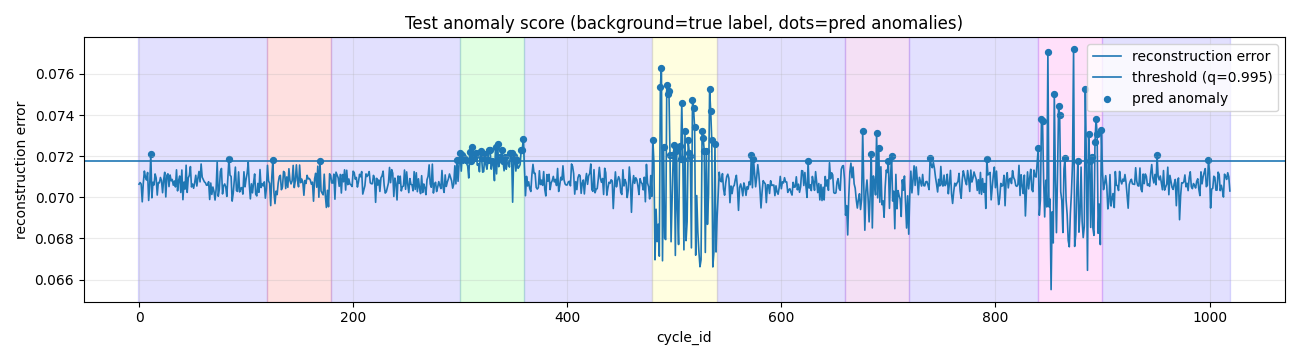

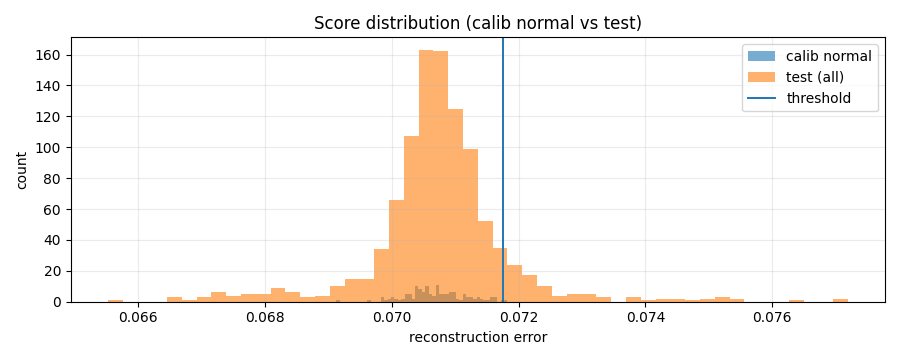

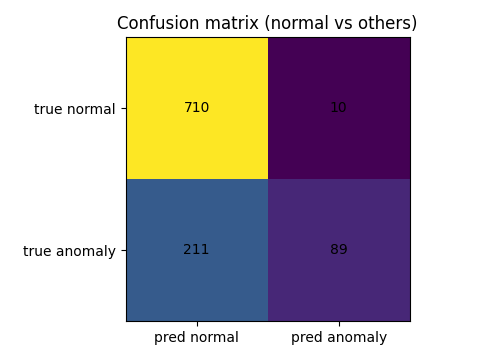


metrics: {'acc': 0.7833333333333333, 'tpr(recall)': 0.2966666666666667, 'fpr': 0.013888888888888888, 'tp': 89, 'tn': 710, 'fp': 10, 'fn': 211}


In [16]:
%matplotlib widget
# ============================================================
# 9) 可視化（スコア時系列 / 分布 / 混同行列）
# ============================================================
label_name  = {0:"正常",1:"上下",2:"横ずれ",3:"周波数",4:"スパイク",5:"mix"}
label_color = {0:"#1100fd",1:"#f80303",2:"#00ff15",3:"#fffb00",4:"#ab00b1",5:"#ff00dd"}

order = np.argsort(cidte)
cid_s   = cidte[order]
y_s     = yte[order]
score_s = score_te[order]
pred_s  = pred_te[order]

# 図1) テスト全体：スコア時系列 + 閾値 + 背景(真ラベル) + 予測異常マーク
plt.figure(figsize=(13, 3.6))
plt.plot(cid_s, score_s, linewidth=1.2, label="reconstruction error")
plt.axhline(thr, linewidth=1.2, label=f"threshold (q={THR_Q})")

start = 0
while start < len(cid_s):
    lab = int(y_s[start])
    end = start
    while end < len(cid_s) and int(y_s[end]) == lab:
        end += 1
    x0 = cid_s[start] - 0.5
    x1 = cid_s[end-1] + 0.5
    plt.axvspan(x0, x1, alpha=0.12, color=label_color.get(lab, "#ffffff"))
    start = end

idx_anom = np.where(pred_s == 1)[0]
plt.scatter(cid_s[idx_anom], score_s[idx_anom], s=18, marker="o", label="pred anomaly")

plt.xlabel("cycle_id")
plt.ylabel("reconstruction error")
plt.title("Test anomaly score (background=true label, dots=pred anomalies)")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 図2) 分布：calib正常 vs テスト
plt.figure(figsize=(9.0, 3.6))
plt.hist(score_cal, bins=50, alpha=0.6, label="calib normal")
plt.hist(score_te,  bins=50, alpha=0.6, label="test (all)")
plt.axvline(thr, linewidth=1.4, label="threshold")
plt.xlabel("reconstruction error")
plt.ylabel("count")
plt.title("Score distribution (calib normal vs test)")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 図3) 混同行列（正常 vs それ以外）
tp = int(np.sum((pred_te == 1) & (y_te_bin == 1)))
tn = int(np.sum((pred_te == 0) & (y_te_bin == 0)))
fp = int(np.sum((pred_te == 1) & (y_te_bin == 0)))
fn = int(np.sum((pred_te == 0) & (y_te_bin == 1)))

cm = np.array([[tn, fp],
               [fn, tp]], dtype=int)

plt.figure(figsize=(4.8, 3.6))
plt.imshow(cm, interpolation="nearest")
plt.xticks([0,1], ["pred normal", "pred anomaly"])
plt.yticks([0,1], ["true normal", "true anomaly"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.title("Confusion matrix (normal vs others)")
plt.tight_layout()
plt.show()

acc2 = (tp + tn) / max(1, tp + tn + fp + fn)
tpr  = tp / max(1, tp + fn)
fpr  = fp / max(1, fp + tn)
print("\nmetrics:", {"acc": acc2, "tpr(recall)": tpr, "fpr": fpr, "tp": tp, "tn": tn, "fp": fp, "fn": fn})